# Resume Parsing

## 1. Load data

In [1]:
import pandas as pd
import numpy as np

df_resume = pd.read_csv("data/resume.csv")

In [2]:
df_resume.Category.unique()

array(['HR', 'DESIGNER', 'INFORMATION-TECHNOLOGY', 'TEACHER', 'ADVOCATE',
       'BUSINESS-DEVELOPMENT', 'HEALTHCARE', 'FITNESS', 'AGRICULTURE',
       'BPO', 'SALES', 'CONSULTANT', 'DIGITAL-MEDIA', 'AUTOMOBILE',
       'CHEF', 'FINANCE', 'APPAREL', 'ENGINEERING', 'ACCOUNTANT',
       'CONSTRUCTION', 'PUBLIC-RELATIONS', 'BANKING', 'ARTS', 'AVIATION'],
      dtype=object)

In [3]:
df_resume.shape

(2484, 4)

In [4]:
df_resume = df_resume.reindex(np.random.permutation(df_resume.index))
df_resume = df_resume.copy().iloc[:1000, ]
df_resume.shape

(1000, 4)

## 2. Load skill data

If we define patterns for all the skill, we gonna be too tired.

So spacy knows that, so it allows you to give you a list of words, then it will automatically create pattern.

In [5]:
import spacy

nlp = spacy.load('en_core_web_md')
skill_path = 'data/skills.jsonl'

('CARDINAL',
 'DATE',
 'EVENT',
 'FAC',
 'GPE',
 'LANGUAGE',
 'LAW',
 'LOC',
 'MONEY',
 'NORP',
 'ORDINAL',
 'ORG',
 'PERCENT',
 'PERSON',
 'PRODUCT',
 'QUANTITY',
 'TIME',
 'WORK_OF_ART')

In [6]:
ruler = nlp.add_pipe("entity_ruler")
ruler.from_disk(skill_path)
nlp.pipe_names

['tok2vec',
 'tagger',
 'parser',
 'attribute_ruler',
 'lemmatizer',
 'ner',
 'entity_ruler']

In [7]:
doc = nlp("Chaky loves ajax.")
doc.ents

(Chaky, ajax)

## 3. Let's try to extract skills from this resume.csv

In [8]:
df_resume.head()

,ID,Resume_str,Resume_html,Category
966,16661264,NATURAL RESOURCE SPECIALIST GS-12/5 ...,"<div class=""LCA skn-ctp2 fontsize fontface vma...",AGRICULTURE
706,20748468,HEALTHCARE ADMINISTRATOR/OPERATIONAL ...,"<div class=""fontsize fontface vmargins hmargin...",HEALTHCARE
135,41506705,MECHANICAL DESIGNER Professiona...,"<div class=""fontsize fontface vmargins hmargin...",DESIGNER
1898,80053367,GENERAL ACCOUNTANT Career F...,"<div class=""fontsize fontface vmargins hmargin...",ACCOUNTANT
1483,26767199,FINANCE MANAGER Summary F...,"<div class=""fontsize fontface vmargins hmargin...",FINANCE


In [9]:
#clean our data
from spacy.lang.en.stop_words import STOP_WORDS

def preprocessing(sentence):
    stopwords    = list(STOP_WORDS)
    doc          = nlp(sentence)
    clean_tokens = []
    
    for token in doc:
        if token.text not in stopwords and token.pos_ != 'PUNCT' and token.pos_ != 'SYM' and \
            token.pos_ != 'SPACE':
                clean_tokens.append(token.lemma_.lower().strip())
                
    return " ".join(clean_tokens)

In [10]:
random_resume = df_resume.Resume_str.iloc[5]
random_resume[:300]

'         ACCOUNT EXECUTIVE       Summary     Exceptional Sales Professional who consistently achieves annual sales objectives and increases the overall customer base. Effectively grows brand awareness through increased market penetration and new market development.       Highlights          National'

In [11]:
preprocessing(random_resume[:300])

'account executive summary exceptional sales professional consistently achieve annual sale objective increase overall customer base effectively grow brand awareness increase market penetration new market development highlight national'

In [12]:
for i, row in df_resume.iterrows():
    clean_text = preprocessing(row.Resume_str)
    df_resume.at[i, 'Clean_resume'] = clean_text

In [13]:
df_resume.head()

,ID,Resume_str,Resume_html,Category,Clean_resume
966,16661264,NATURAL RESOURCE SPECIALIST GS-12/5 ...,"<div class=""LCA skn-ctp2 fontsize fontface vma...",AGRICULTURE,natural resource specialist gs-12/5 position a...
706,20748468,HEALTHCARE ADMINISTRATOR/OPERATIONAL ...,"<div class=""fontsize fontface vmargins hmargin...",HEALTHCARE,healthcare administrator operational and staff...
135,41506705,MECHANICAL DESIGNER Professiona...,"<div class=""fontsize fontface vmargins hmargin...",DESIGNER,mechanical designer professional profile ​ des...
1898,80053367,GENERAL ACCOUNTANT Career F...,"<div class=""fontsize fontface vmargins hmargin...",ACCOUNTANT,general accountant career focus to obtain posi...
1483,26767199,FINANCE MANAGER Summary F...,"<div class=""fontsize fontface vmargins hmargin...",FINANCE,finance manager summary flexible financial man...


## 4. Let's really extract skills!!

In [14]:
def get_skills(text):
    
    doc = nlp(text)
    
    skills = []
    
    for ent in doc.ents:
        if ent.label_ == 'SKILL':
            skills.append(ent.text)
            
    return skills

def unique_skills(x):
    return list(set(x))

In [ ]:
nlp.get_pipe("ner").labels

In [15]:
df_resume['Skills'] = df_resume.Clean_resume.apply(get_skills)
df_resume['Skills'] = df_resume.Skills.apply(unique_skills)

In [16]:
df_resume.Skills.iloc[0]

['documentation', 'advertising', 'rancher', 'monitoring']

In [38]:
nlp(text).ents[0].label_

'PERSON'

## 5. Visualization

Which skills is most important in information management?

In [17]:
# set(df_resume.Category)

In [18]:
category = 'INFORMATION-TECHNOLOGY'
cond = df_resume.Category == category

df_resume_it = df_resume[cond]
df_resume_it.shape

(51, 6)

In [19]:
all_skills = np.concatenate(df_resume_it.Skills.values)

In [20]:
from collections import Counter, OrderedDict

counting = Counter(all_skills)
counting = OrderedDict(counting.most_common(10))

In [21]:
counting

OrderedDict([('support', 49),
             ('software', 44),
             ('design', 39),
             ('security', 34),
             ('business', 32),
             ('windows', 30),
             ('server', 28),
             ('documentation', 27),
             ('database', 25),
             ('project management', 23)])

<BarContainer object of 10 artists>

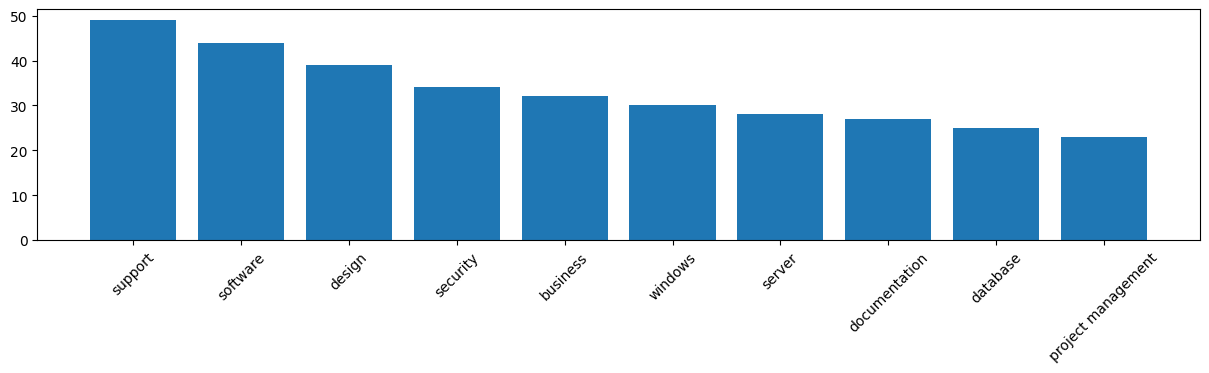

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 3))
plt.xticks(rotation=45)

plt.bar(counting.keys(), counting.values())

## 6. Name Entity Recognition

In [23]:
from spacy import displacy

text = df_resume_it.Clean_resume.iloc[32]

In [24]:
doc = nlp(text)

In [25]:
# colors = {"SKILL": "linear-gradient(90deg, #aa9cfc, #fc9ce7)"}
# options = {"colors": colors}

# displacy.render(doc, style='ent', options=options)

## 7. Let's load the PDF - add some realism

In [43]:
from PyPDF2 import PdfReader

reader = PdfReader("data/chaklam_resume.pdf")
page = reader.pages[0]
text = page.extract_text()

In [44]:
text = preprocessing(text)

In [45]:
doc = nlp(text)

In [46]:
doc

chaklam silpasuwanchai email chaklam@ait.asia http://chaklam.com mobile +66 - 63 310 - 9191 http://github.com/chaklam-silpasuwanchai skill •language python java •tool frameworks pytorch springboot •theory machine deep learning natural language processing software engineering hypothesis testing data structures algorithms selected projects •bci speller develop real time speller eeg lock patient •large language models develop conversational ai legal question answering university chatbot summarization etc . large language model •non invasive blood glucose measuring use raman spectroscopy utilize raman spectroscopy non - invasively measure blood glucose fingernail •medical imaging utilize deep learning language model medical image analysis explanation working experience •asian institute technology pathumthani thailand assistant professor school engineering technology january 2019 present •stamford international university bangkok thailand faculty it program faculty business technology march

In [29]:
colors = {"SKILL": "linear-gradient(90deg, #aa9cfc, #fc9ce7)"}
options = {"colors": colors}

displacy.render(doc, style='ent', options=options)

## 8. Additional Features

### Obtain entities table

Let's obtain an entities table to find all entities for each entity type that exist in the resume.

In [168]:
# modified from get_skill function
def get_entities(text):
    
    doc = nlp(text)
    
    entities = {}
    
    for ent in doc.ents:
        if ent.label_ in entities:
            entities[ent.label_].append(ent.text)
        else:
            entities[ent.label_] = [ent.text]

    for ent_type in entities.keys():
        entities[ent_type] = ', '.join(unique_list(entities[ent_type]))
            
    return pd.DataFrame.from_dict(entities, orient='index', columns=['entities'])

def unique_list(x):
    return list(set(x))

In [169]:
resume_ents = get_entities(text)
resume_ents

,entities
PERSON,pananookooln c. akaranee j. silpasuwanchai c. ...
SKILL,"computer science, language model, deep learnin..."
QUANTITY,"1.463 3 niksirat ks, 310 - 9191"
PRODUCT,"google, •non"
ORG,"•medical, kochi japan, •kasetsart university, ..."
DATE,"26 2023 1, 17(1 2018, 2023, march 2017 decembe..."
GPE,thailand
CARDINAL,"26 6, 2.390 5, 2.227, 4.00, 3.82, 11 561, 5, 3..."
ORDINAL,first


### Find all people names

Person entities using the entity rule are not perfect. Let's use matcher to identify persons in the resume better

In [263]:
from spacy.matcher import Matcher

In [264]:
matcher = Matcher(nlp.vocab)
pattern = [
    {"POS": "PROPN",  # person's name should be a proper noun
     "OP": "{2}",  # person's name usually consists of 2 parts; first name and last name (in some scenario, 3 if a person has middle name)
     "ENT_TYPE": "PERSON"  # person's name is of 'PERSON' entity type
    },
]
matcher.add("PERSON NAME", [pattern], greedy="LONGEST")

In [265]:
matches = matcher(doc)
matches.sort(key = lambda x: x[1])

In [266]:
person_names = []

for match in matches:
    person_names.append((str(doc[match[1]:match[2]]),
                         nlp.vocab.strings[match[0]]))

person_names = list(set(person_names))
person_names

[('jokinen j.', 'PERSON NAME'),
 ('akaranee j.', 'PERSON NAME'),
 ('silpasuwanchai c.', 'PERSON NAME'),
 ('roman w.', 'PERSON NAME'),
 ('wang z.', 'PERSON NAME'),
 ('ren x.', 'PERSON NAME'),
 ('oulasvirta a.', 'PERSON NAME'),
 ('sarcar s.', 'PERSON NAME'),
 ('chaklam silpasuwanchai', 'PERSON NAME'),
 ('pananookooln c.', 'PERSON NAME')]

In [267]:
matcher.add("EMAIL", [[{"LIKE_EMAIL": True}]], greedy="LONGEST")
matcher.add("URL", [[{"LIKE_URL": True}]], greedy="LONGEST")

In [268]:
matches = matcher(doc)
matches.sort(key = lambda x: x[1])

In [269]:
entities = []

for match in matches:
    entities.append((str(doc[match[1]:match[2]]),
                         nlp.vocab.strings[match[0]]))

entities = list(set(entities))
entities

[('jokinen j.', 'PERSON NAME'),
 ('http://github.com/chaklam-silpasuwanchai', 'URL'),
 ('akaranee j.', 'PERSON NAME'),
 ('http://chaklam.com', 'URL'),
 ('silpasuwanchai c.', 'PERSON NAME'),
 ('roman w.', 'PERSON NAME'),
 ('https://doi.org/10.1145/3359593', 'URL'),
 ('ren x.', 'PERSON NAME'),
 ('chaklam@ait.asia', 'EMAIL'),
 ('oulasvirta a.', 'PERSON NAME'),
 ('wang z.', 'PERSON NAME'),
 ('sarcar s.', 'PERSON NAME'),
 ('chaklam silpasuwanchai', 'PERSON NAME'),
 ('pananookooln c.', 'PERSON NAME')]